In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../..')

In [2]:
from src.wess_zumino_model import WessZuminoModel
from src.matrix_to_ps import matrix_to_pse
from src.binary_encodings import standard_encode
from src.qiskit_utilities import pauli_dict_to_op, op_to_trotter


from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import RealAmplitudes
from qiskit import BasicAer
from qiskit import qpy
from qiskit import QuantumCircuit, transpile


import scipy.sparse.linalg
import sympy as sp
import numpy as np

from ipywidgets import IntProgress
from IPython.display import display, clear_output 

import matplotlib.pyplot as plt

import json
import math

In [3]:
def potential(self, n):
    # m*q with m=1
    return -self.mass*self.qs[n]

N=2
wz=WessZuminoModel(N,1.0,potential,'dirichlet')

## TODO 

* NCount/Excitation preserving?  Can I get them to work - do we want to bother? 
* MORE iterations for more reps/make plot of trend/consider accuracy vs gates vs iteration number
* Iterative VQE for lowest three states, non-zero states always paired.  zero E state is unique -> SSYM

In [4]:
cutoff=16
wz.construct_ham_matrix(cutoff)
e0=scipy.sparse.linalg.eigs(wz.hamMat,k=1,sigma=0.0)[0]
ps=matrix_to_pse(wz.hamMat, standard_encode)
op=pauli_dict_to_op(ps.to_dict())

nq=math.floor(math.log2(wz.hamMat.shape[0]))
if not math.log2(wz.hamMat.shape[0]).is_integer():
    nq+=1

In [22]:
backend = BasicAer.get_backend("statevector_simulator")

#results={}

vqeRuns=50

style = {'description_width': 'initial'}
layout = {'width':'600px'}

#for entanglement in ['linear','reverse_linear','circular','sca']: #full and reverse linear are same, reverse has less gates
for entanglement in ['reverse_linear','circular','sca']: #full and reverse linear are same, reverse has less gates
    results[entanglement]={}
    for reps in [1,2,4,8]:
        ansatz = RealAmplitudes(nq, entanglement=entanglement, reps=reps)
        vqe = VQE(ansatz=ansatz, optimizer=COBYLA(), quantum_instance=backend)
        
        values=[]
        progress = IntProgress(min=0, max=vqeRuns, description="Running VQE with {} entanglement and {} reps".format(entanglement,reps), style=style, layout=layout)
        display(progress)
        for run in range(vqeRuns):
            values.append(vqe.compute_minimum_eigenvalue(op).eigenvalue.real)
            progress.value += 1
            
        results[entanglement][reps]=values
    
        with open('Data/vqe_linear_real_amplitudes.json','w') as file:
            json.dump(results, file)
        
        clear_output()


In [27]:
results_real_amplitudes=results

In [28]:
from qiskit.circuit.library import ExcitationPreserving

results={}

vqeRuns=50

style = {'description_width': 'initial'}
layout = {'width':'600px'}

for entanglement in ['linear','reverse_linear','circular','sca']: #full and reverse linear are same, reverse has less gates
    results[entanglement]={}
    for reps in [1,2,4,8]:
        ansatz = ExcitationPreserving(nq, entanglement=entanglement, reps=reps)
        vqe = VQE(ansatz=ansatz, optimizer=COBYLA(), quantum_instance=backend)
        
        values=[]
        progress = IntProgress(min=0, max=vqeRuns, description="Running VQE with {} entanglement and {} reps".format(entanglement,reps), style=style, layout=layout)
        display(progress)
        for run in range(vqeRuns):
            values.append(vqe.compute_minimum_eigenvalue(op).eigenvalue.real)
            progress.value += 1
            
        results[entanglement][reps]=values
    
        with open('Data/vqe_linear_excitation_preserving.json','w') as file:
            json.dump(results, file)
        
        clear_output()

## VQE Results

In [4]:
data={}
raFile=open('Data/vqe_linear_real_amplitudes.json')
data['RealAmplitudes']=json.load(raFile)
epFile=open('Data/vqe_linear_excitation_preserving.json')
data['ExcitationPreserving']=json.load(epFile)

In [12]:
np.array(data['RealAmplitudes']['linear']['1']).min()

0.11803403060800956

In [13]:
import matplotlib.pyplot as plt

In [17]:
data['RealAmplitudes'].keys()

dict_keys(['linear', 'reverse_linear', 'circular', 'sca'])

Text(0.5, 1.0, 'RealAmplitudes')

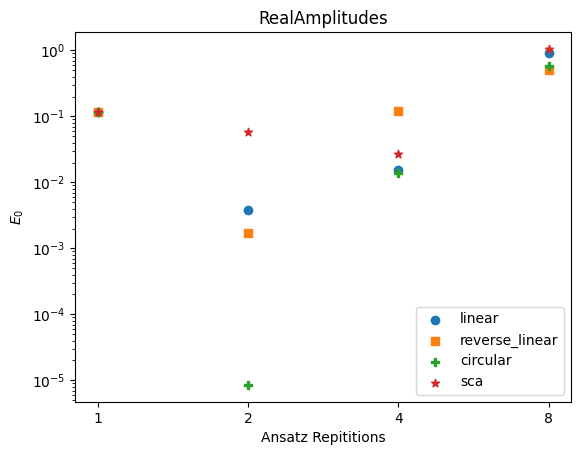

In [34]:
amp='RealAmplitudes'
entanglements=data[amp].keys()

markers=['o','s','P','*']

for i,entanglement in enumerate(entanglements):
    eMin = []
    reps=data[amp][entanglement].keys()
    for rep in reps:
        eMin.append(np.array(data[amp][entanglement][str(rep)]).min())

    plt.scatter(reps,eMin,marker=markers[i],label=entanglement)

plt.yscale('log')
plt.xlabel('Ansatz Repititions')
plt.ylabel(r'$E_0$')
plt.legend(loc='lower right')
plt.title(amp)

Text(0.5, 1.0, 'ExcitationPreserving')

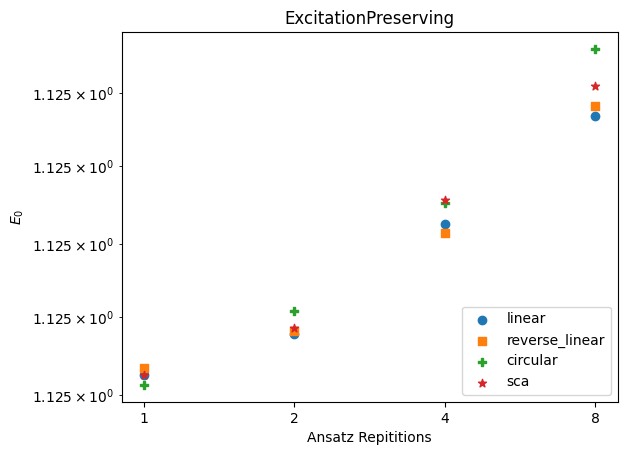

In [35]:
amp='ExcitationPreserving'
entanglements=data[amp].keys()

markers=['o','s','P','*']

for i,entanglement in enumerate(entanglements):
    eMin = []
    reps=data[amp][entanglement].keys()
    for rep in reps:
        eMin.append(np.array(data[amp][entanglement][str(rep)]).min())

    plt.scatter(reps,eMin,marker=markers[i],label=entanglement)

plt.yscale('log')
plt.xlabel('Ansatz Repititions')
plt.ylabel(r'$E_0$')
plt.legend(loc='lower right')
plt.title(amp)

In [44]:
scipy.sparse.linalg.eigs(wz.hamMat, k=13, sigma=0.0)[0]

array([5.3902832e-10-1.2826014e-20j, 1.1213071e+00+1.8621320e-08j,
       1.1180325e+00-9.3132000e-09j, 1.1180333e+00-3.6088704e-08j,
       1.1180347e+00-4.3347428e-09j, 2.2520225e+00+1.9405613e-06j,
       2.2360713e+00-3.8743133e-06j, 2.2360718e+00+3.5646490e-06j,
       3.3540955e+00-5.0251792e-08j, 2.2360654e+00-7.8943394e-08j,
       2.2360673e+00-4.2393069e-08j, 2.2360682e+00+5.8549475e-08j,
       3.3541012e+00+9.4293711e-08j], dtype=complex64)

## Examining RealAmplitudes with 4 reps

In [29]:
e0estimates={}
iterCounts={}
iterValues={}
iterErrs={}
iterParams={}
vqeRuns={}

In [31]:
backend = BasicAer.get_backend("statevector_simulator")

#results={}

vqeRuns=20

entanglement='circular'
reps=2
repsName='{} Reps'.format(reps)

def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)
    err.append(std)
    params.append(parameters)

ansatz = RealAmplitudes(nq, entanglement=entanglement, reps=reps)
vqe = VQE(ansatz=ansatz, optimizer=COBYLA(), quantum_instance=backend, callback=store_intermediate_result)

e0estimates[repsName]=[]
iterCounts[repsName]={}
iterValues[repsName]={}
iterErrs[repsName]={}
iterParams[repsName]={}

for run in range(vqeRuns):
    counts=[]
    values=[]
    err=[]
    params=[]
    e0estimates[repsName].append(vqe.compute_minimum_eigenvalue(op).eigenvalue.real)
    iterCounts[repsName][run]=counts
    iterValues[repsName][run]=values
    iterErrs[repsName][run]=err
    iterParams[repsName][run]=params

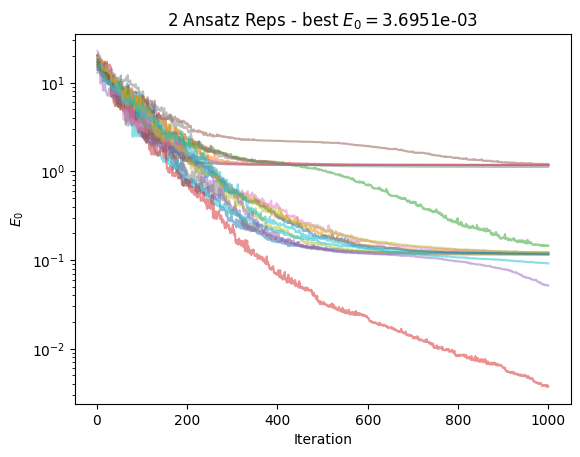

In [34]:
for run in range(len(e0estimates[repsName])):
    plt.plot(iterCounts[repsName][run],iterValues[repsName][run], alpha=0.5)
plt.xlabel('Iteration')
plt.ylabel(r'$E_0$')
plt.title(r'2 Ansatz Reps - best $E_0=${:.4e}'.format(np.array(e0estimates[repsName]).min()))
plt.yscale('log')

In [35]:
backend = BasicAer.get_backend("statevector_simulator")

#results={}

vqeRuns=40

entanglement='circular'
reps=4
repsName='{} Reps'.format(reps)

def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)
    err.append(std)
    params.append(parameters)

ansatz = RealAmplitudes(nq, entanglement=entanglement, reps=reps)
vqe = VQE(ansatz=ansatz, optimizer=COBYLA(), quantum_instance=backend, callback=store_intermediate_result)

e0estimates[repsName]=[]
iterCounts[repsName]={}
iterValues[repsName]={}
iterErrs[repsName]={}
iterParams[repsName]={}

for run in range(vqeRuns):
    counts=[]
    values=[]
    err=[]
    params=[]
    e0estimates[repsName].append(vqe.compute_minimum_eigenvalue(op).eigenvalue.real)
    iterCounts[repsName][run]=counts
    iterValues[repsName][run]=values
    iterErrs[repsName][run]=err
    iterParams[repsName][run]=params


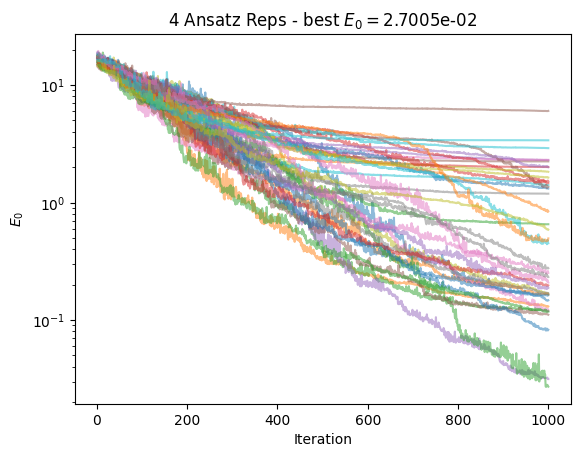

In [36]:
for run in range(len(e0estimates[repsName])):
    plt.plot(iterCounts[repsName][run],iterValues[repsName][run], alpha=0.5)
plt.xlabel('Iteration')
plt.ylabel(r'$E_0$')
plt.title(r'4 Ansatz Reps - best $E_0=${:.4e}'.format(np.array(e0estimates[repsName]).min()))
plt.yscale('log')

In [37]:
backend = BasicAer.get_backend("statevector_simulator")

#results={}

vqeRuns=5

entanglement='circular'
reps=4
repsName='{} Reps'.format(reps)

def store_intermediate_result(eval_count, parameters, mean, std):2
    counts.append(eval_count)
    values.append(mean)
    err.append(std)
    params.append(parameters)

ansatz = RealAmplitudes(nq, entanglement=entanglement, reps=reps)
vqe = VQE(ansatz=ansatz, optimizer=COBYLA(maxiter=5000), quantum_instance=backend, callback=store_intermediate_result)

e0estimates[repsName]=[]
iterCounts[repsName]={}
iterValues[repsName]={}
iterErrs[repsName]={}
iterParams[repsName]={}

for run in range(vqeRuns):
    counts=[]
    values=[]
    err=[]
    params=[]
    e0estimates[repsName].append(vqe.compute_minimum_eigenvalue(op).eigenvalue.real)
    iterCounts[repsName][run]=counts
    iterValues[repsName][run]=values
    iterErrs[repsName][run]=err
    iterParams[repsName][run]=params

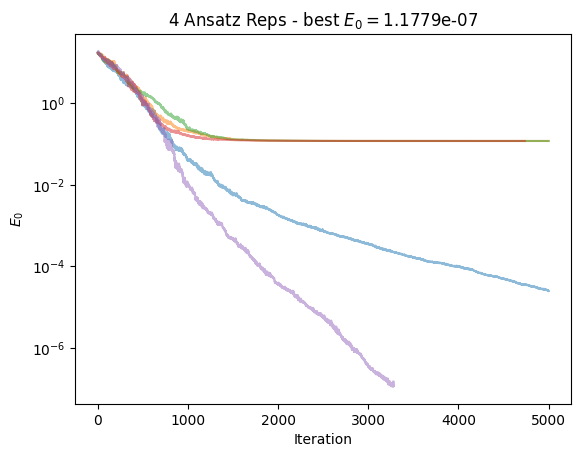

In [38]:
for run in range(len(e0estimates[repsName])):
    plt.plot(iterCounts[repsName][run],iterValues[repsName][run], alpha=0.5)
plt.xlabel('Iteration')
plt.ylabel(r'$E_0$')
plt.title(r'4 Ansatz Reps - best $E_0=${:.4e}'.format(np.array(e0estimates[repsName]).min()))
plt.yscale('log')

## New VQE....

In [5]:
from qiskit.primitives import Estimator
estimator = Estimator()

from qiskit.algorithms.minimum_eigensolvers import VQE

entanglement='circular'
reps=1
repsName='{} Reps'.format(reps)

ansatz = RealAmplitudes(nq, entanglement=entanglement, reps=reps)
vqe = VQE(estimator, ansatz, COBYLA(maxiter=5000))

result=vqe.compute_minimum_eigenvalue(op)

In [6]:
print(result)

{   'aux_operators_evaluated': None,
    'cost_function_evals': 928,
    'eigenvalue': 1.1774368872823908,
    'optimal_circuit': <qiskit.circuit.library.n_local.real_amplitudes.RealAmplitudes object at 0x7fafa1ae3cd0>,
    'optimal_parameters': {   ParameterVectorElement(θ[12]): 1.491971473716204,
                              ParameterVectorElement(θ[9]): 3.004498302307171e-05,
                              ParameterVectorElement(θ[10]): -3.141629424992955,
                              ParameterVectorElement(θ[11]): -3.6295198871807663,
                              ParameterVectorElement(θ[14]): 4.712343281802448,
                              ParameterVectorElement(θ[13]): -1.5708449534533642,
                              ParameterVectorElement(θ[19]): 0.7777932443421437,
                              ParameterVectorElement(θ[17]): -1.6784025219636491,
                              ParameterVectorElement(θ[18]): 2.001203235189097,
                              ParameterVectorElem

In [7]:
print(result.optimal_circuit.decompose().draw())

     ┌──────────┐┌───┐     ┌───────────┐                                       »
q_0: ┤ Ry(θ[0]) ├┤ X ├──■──┤ Ry(θ[10]) ├───────────────────────────────────────»
     ├──────────┤└─┬─┘┌─┴─┐└───────────┘┌───────────┐                          »
q_1: ┤ Ry(θ[1]) ├──┼──┤ X ├──────■──────┤ Ry(θ[11]) ├──────────────────────────»
     ├──────────┤  │  └───┘    ┌─┴─┐    └───────────┘┌───────────┐             »
q_2: ┤ Ry(θ[2]) ├──┼───────────┤ X ├──────────■──────┤ Ry(θ[12]) ├─────────────»
     ├──────────┤  │           └───┘        ┌─┴─┐    └───────────┘┌───────────┐»
q_3: ┤ Ry(θ[3]) ├──┼────────────────────────┤ X ├──────────■──────┤ Ry(θ[13]) ├»
     ├──────────┤  │                        └───┘        ┌─┴─┐    └───────────┘»
q_4: ┤ Ry(θ[4]) ├──┼─────────────────────────────────────┤ X ├──────────■──────»
     ├──────────┤  │                                     └───┘        ┌─┴─┐    »
q_5: ┤ Ry(θ[5]) ├──┼──────────────────────────────────────────────────┤ X ├────»
     ├──────────┤  │        

In [ ]:
print(result.optimal_circuit.draw())